# Brain iMRI : Pre-Processing

In [85]:
import pandas as pd
import os
import json
import numpy as np 
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import normaltest
import scipy.stats as stats


# I - Pre-analysis

### Before proceeding to MRI analyses, we must conduct a pre-analysis of test subjects : indeed their score in each category will be computed with machine learning algorithms

## 1 - Preliminary data cleaning

In [86]:
# Load phenotype data associated with participants
phenotype_path = '/home/skander/ds004920/phenotype/'

# List all files in the phenotype directory
files = os.listdir(phenotype_path)

# Initialize an empty DataFrame to accumulate phenotype data
all_phenotype_data = pd.DataFrame()

# Process each file
for file in files:
    file_path = os.path.join(phenotype_path, file)

    if file.endswith('.tsv'):
        # Load TSV file, considering multiple formats as NaN
        temp_df = pd.read_csv(file_path, sep='\t', na_values=['n/a', 'NA', 'na', 'N/A', ''])
        # Append the data from each TSV file to the accumulated DataFrame
        all_phenotype_data = pd.concat([all_phenotype_data, temp_df], ignore_index=True)

# Aggregate the values for each phenotype
aggregated_phenotype_data = all_phenotype_data.groupby('participant_id').sum().reset_index()

# Load participants data
participants_path = '/home/skander/ds004920/participants.tsv'
participants_df = pd.read_csv(participants_path, sep='\t', na_values=['n/a', 'NA', 'na', 'N/A', ''])

# Merge aggregated phenotype data with participants data
combined_df = pd.merge(participants_df, aggregated_phenotype_data, on='participant_id', how='left')

# Display the first few rows of the combined DataFrame
#print(combined_df.head())

# Define the file path for the CSV file in your /home directory
#csv_file_path = '/home/skander/combined1.csv'

# Save the combined DataFrame as a CSV file
#combined_df.to_csv(csv_file_path, index=False)


We make it simpler by making an overall score, indeed 437 columns cannot give any information

In [87]:
# Replace NaN or N/A values with 0
combined_df = combined_df.replace('N/A', 0).fillna(0)

# Remove duplicates, keeping the first occurrence
combined_df = combined_df.drop_duplicates(subset='participant_id', keep='first')

# Truncate the decimal places in 'screen_BMI' and 'age' without rounding
combined_df['screen_bmi'] = combined_df['screen_bmi'].apply(lambda x: np.floor(x))
combined_df['age'] = combined_df['age'].apply(lambda x: np.floor(x))

# Function to sum columns based on containing specific substrings
def sum_columns(df, substrings):
    for substring, new_col_name in substrings.items():
        # Select columns that contain the specific substring
        selected_columns = df.filter(like=substring).columns

        # Sum these columns and create a new column
        df[new_col_name] = df[selected_columns].sum(axis=1)

        #drop the original columns
        df.drop(selected_columns, axis=1, inplace=True)

# Dictionary mapping substrings to new column names
substrings_to_merge = {
    'aadis': 'juvenile_drug_alcohol_use',
    'audit': 'Alcohol_use',
    'asrm': 'Mania_Scale',
    'aq': 'Autism_Quotient',
    'bdi': 'Back_depression_inventory',
    'bisbas': 'Inhibited',
    'bpaq': 'Aggressive',
    'ctqsf_adult_c': 'Childhood_trauma',
    'dudit': 'Drug_Use',
    'ios_computer': 'PC_use',
    'ios_p': 'Friend_behavior',
    'ios_fu_score': 'Stranger_behavior',
    'iri': 'Interpersonal_Reactivity_Index',
    'pnr': 'Social_reactivity',
    'pvss': 'Positivity',
    'quic_adult_cj': 'Unpredictability_in_Childhood',
    'rse': 'Self_esteem',
    'spsrq': 'Sensitivity_to_punishment_reward',
    'susd': '7_up_7_down',
    'seq_adult_cj': 'Social_Experience',
    'score_teps': 'Temporal_pleasure',
    'tei': 'Emotional_intelligence'
}

# Perform the column summing based on substrings
sum_columns(combined_df, substrings_to_merge)

# Display the DataFrame for verification
#print(combined_df.head())

# Print all column names in the DataFrame
#print(combined_df.columns.tolist())

we have one column per medication used, we transform it into 2 features : Number of medication, and medication type (tbd : one-hot encore)

In [88]:
# Add a new column for the total drug use
drug_columns = [
    'screen_meds_stabilizer', 'screen_meds_ssri', 'screen_meds_epilepsy', 
    'screen_meds_psychosis', 'screen_meds_antianxiety', 'screen_meds_pain'
]
combined_df['total_drug_use'] = combined_df[drug_columns].sum(axis=1)

# Function to create a list of medication names, removing 'screen_meds_'
def list_medications(row, column_names):
    medications = [col.replace('screen_meds_', '') for col in column_names if row[col] != 0]
    return ', '.join(medications) if medications else 'None'

# Add a new column listing the modified medication names
combined_df['medication_names'] = combined_df.apply(lambda row: list_medications(row, drug_columns), axis=1)

# Columns to be removed
columns_to_remove = [
    'screen_meds_stabilizer', 'screen_meds_ssri', 'screen_meds_epilepsy', 
    'screen_meds_psychosis', 'screen_meds_antianxiety', 'screen_meds_pain'
]

# Removing the specified columns from combined_df
combined_df = combined_df.drop(columns=columns_to_remove)

# Display the DataFrame for verification
#print(combined_df.head())

# Display the DataFrame for verification with a selection of columns
#print(combined_df.columns.tolist())

### Conclusion : Data merged by category, thus we have less granularity, however these results enable a better deep learning and ML process, while 400+ columns would have had unreliable results

## 2 - Preliminary feature engineering

### A - We take values who would be interpreted wrongfully as "better" or "lesser" (an age of 40 would be higher ranked than the age 20, which makes no sense), so let's transform these features into ranges use to categorize relevant data

Transforming individual BMI's into BMI's ranges

In [89]:
import pandas as pd
# Define a function to categorize BMI based on the provided ranges
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi <= 24.9:
        return 'Healthy Weight'
    elif 25 <= bmi <= 29.9:
        return 'Overweight'
    elif 30 <= bmi <= 34.9:
        return 'Obese'
    elif 35 <= bmi <= 39.9:
        return 'Severely Obese'
    else:  # Assuming that any BMI of 40 or above is Morbidly Obese
        return 'Morbidly Obese'

# Apply the function to the 'screen_bmi' column to create a new 'bmi_category' column
combined_df['bmi_category'] = combined_df['screen_bmi'].apply(categorize_bmi)

# drop the original 'screen_bmi' column we won't use
combined_df.drop('screen_bmi', axis=1, inplace=True)


Transforming age into age ranges

In [90]:
# Define the function to categorize age
def categorize_age(age):
    if age <= 12:
        return 'Child'
    elif age <= 17:
        return 'Teen'
    elif age <= 24:
        return 'Young Adult'
    elif age <= 34:
        return 'Adult'
    elif age <= 44:
        return 'Mature Adult'
    elif age <= 54:
        return 'Middle Aged'
    elif age <= 64:
        return 'Senior'
    else:
        return 'Elderly'

# Apply the function to the 'age' column
combined_df['age_category'] = combined_df['age'].apply(categorize_age)

# We drop the original 'age' column as we no longer need it
combined_df.drop('age', axis=1, inplace=True)


saving a csv file for tests

In [91]:
# Define the file path for the CSV file in your /home directory
#csv_file_path = '/home/skander/combined2.csv'

# Save the DataFrame as a CSV file
#combined_df.to_csv(csv_file_path, index=False)

check = ok, results intended, proceeding to the next step

### B - One Hot-encoding categorial variables

#### one hot-encoding is chosen rather than ordinal encoding, there is no hierarchy between data (e.g health and overweight may be interpreted as such, but we cannot say an Obese is hierarchically higher than a healthy or underweight person, it's hierarchy-independant, well it's better to be healthy but mathematically irrelevant)

In [92]:
# List of categorical columns
categorical_columns = ['bmi_category', 'age_category', 'medication_names', 'sex', 'handedness', 'screen_race']

# Apply one-hot encoding
for column in categorical_columns:
    dummies = pd.get_dummies(combined_df[column], prefix=column)
    combined_df = pd.concat([combined_df, dummies], axis=1)
    combined_df.drop(column, axis=1, inplace=True)

### C - Gaussian distribution : normalization vs standardization

#### Determining if we have a gaussian distribution, which is critical to make our model tailored for deep learning

##### Hint 1 - Using histograms for each numerical column to get insights

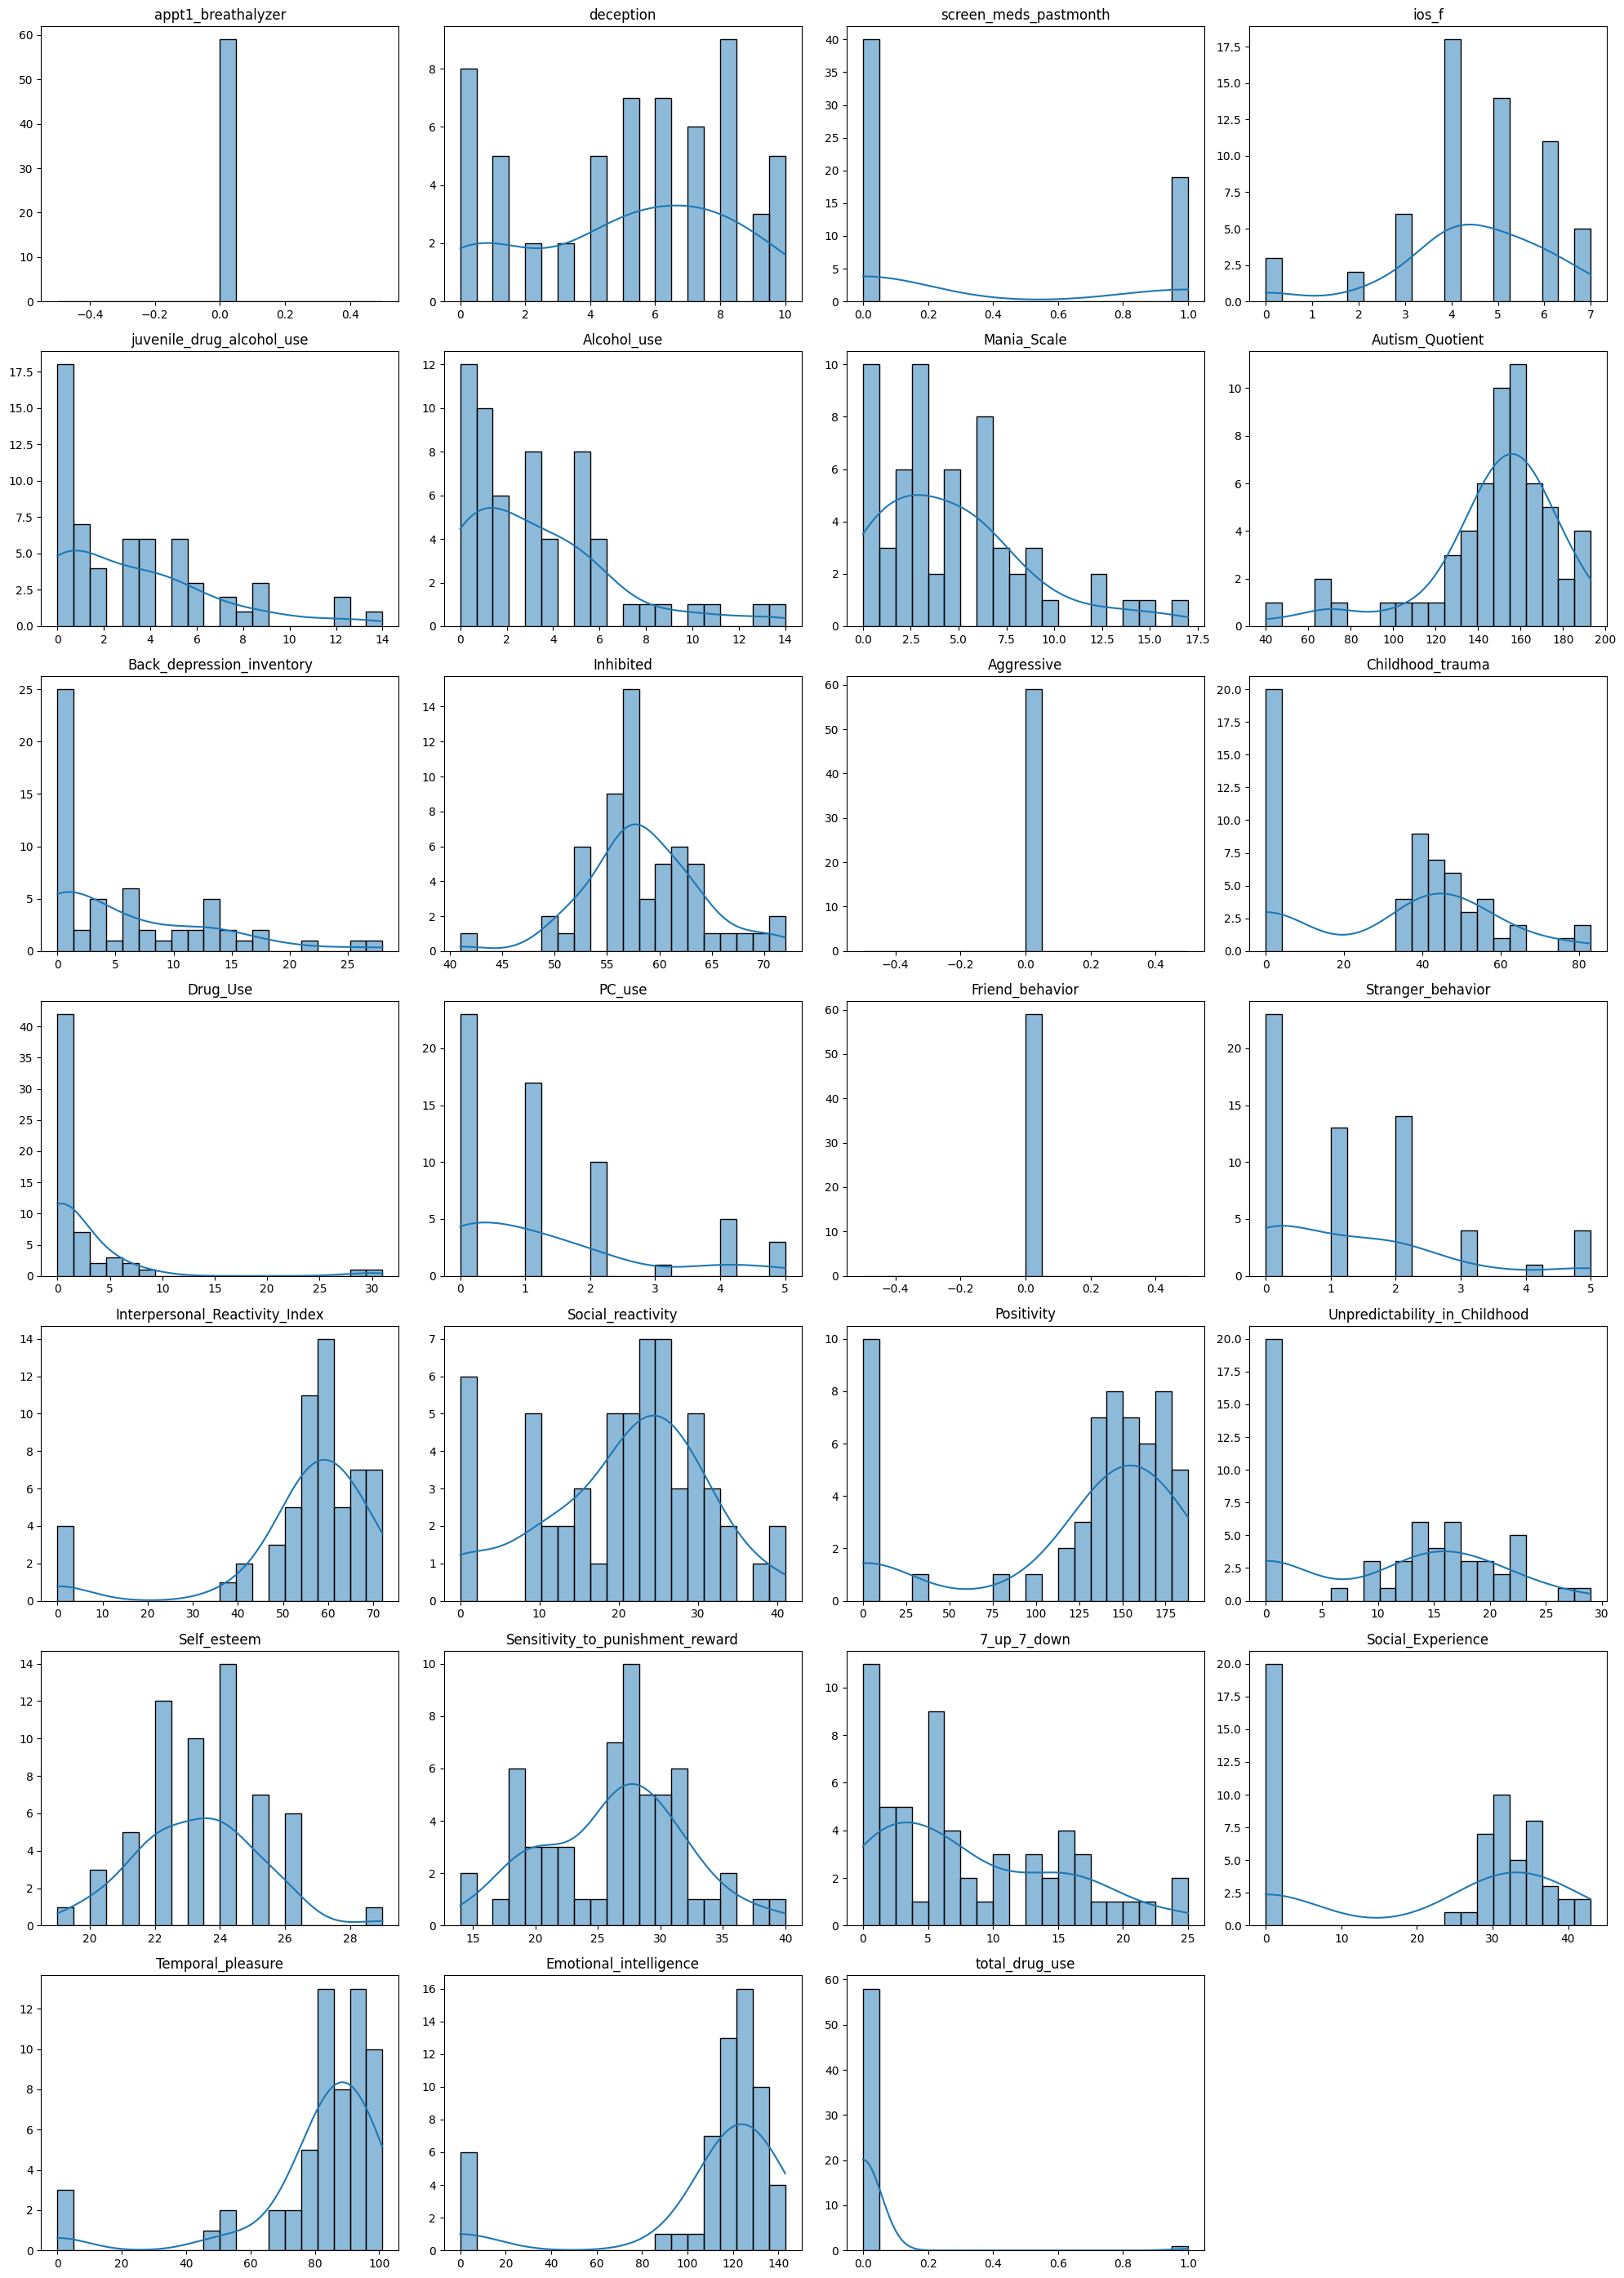

In [93]:
# Select only numeric columns for histogram plotting
numeric_cols = combined_df.select_dtypes(include=[np.number])

num_columns = len(numeric_cols.columns)
num_rows = int(np.ceil(num_columns / 4))  # Adjust the number of columns per row

plt.figure(figsize=(20, 4 * num_rows))

for i, column in enumerate(numeric_cols.columns):
    plt.subplot(num_rows, 4, i + 1)  # Adjust the grid size (rows, cols, index)
    sns.histplot(numeric_cols[column], bins=20, kde=True)
    plt.title(f'{column}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

Some gaussian distributions appear, however for some it's not "obvious", let's delve into our data and try a more robust approach

#### Hint 2 : D’Agostino and Pearson’s test, which is implemented in the normaltest() function from the scipy.stats module, combines skewness and kurtosis to produce an omnibus test of normality.

In [94]:
# Select only numeric columns excluding 'participant_id'
numeric_df = combined_df.select_dtypes(include=[np.number])

# Test each numeric column for normality
normality_results = {}
for column in numeric_df.columns:
    # Drop NaN values to avoid errors in normality test
    stat, p = normaltest(numeric_df[column].dropna())
    normality_results[column] = {'statistic': stat, 'p_value': p}

# Convert the results to a DataFrame for better visualization
normality_df = pd.DataFrame.from_dict(normality_results, orient='index')
print(normality_df)

                                   statistic       p_value
appt1_breathalyzer                       NaN           NaN
deception                          10.829552  4.450335e-03
screen_meds_pastmonth              45.257003  1.487875e-10
ios_f                              10.347921  5.662101e-03
juvenile_drug_alcohol_use          13.799299  1.008138e-03
Alcohol_use                        18.411032  1.004836e-04
Mania_Scale                        12.272537  2.162979e-03
Autism_Quotient                    24.326220  5.219495e-06
Back_depression_inventory          13.753050  1.031723e-03
Inhibited                           3.516888  1.723128e-01
Aggressive                               NaN           NaN
Childhood_trauma                   11.686375  2.899585e-03
Drug_Use                           82.326718  1.327334e-18
PC_use                             13.202277  1.358820e-03
Friend_behavior                          NaN           NaN
Stranger_behavior                  12.789724  1.670117e-

##### Conclusion: 
##### 1 - unlike normal p_values where <0.05 indicates that the data are not normally distributed, and >0.05 suggests that the data do not significantly deviate from normality : Here all values are above that threshold which indicates we cannot rule-out to reject the null hypothesis of normality.
##### 2 - D’Agostino and Pearson seems to indicate that a low statistic and a high p_value indicates a stronger distribution. NaN values: Indicate that the test could not be performed, likely due to the column having constant or null values only.

#### Hint 2.bis : test our hypothesis. 

In [95]:
# Create a copy of normality_df
normality_df_cleaned = normality_df.copy()

# Normalize the 'statistic' and 'p_value' columns to be between 0 and 1
normality_df_cleaned['statistic_norm'] = (normality_df_cleaned['statistic'] - normality_df_cleaned['statistic'].min()) / (normality_df_cleaned['statistic'].max() - normality_df_cleaned['statistic'].min())
normality_df_cleaned['p_value_norm'] = (normality_df_cleaned['p_value'] - normality_df_cleaned['p_value'].min()) / (normality_df_cleaned['p_value'].max() - normality_df_cleaned['p_value'].min())

# Calculate the indicative value for each column
normality_df_cleaned['indicative_value'] = normality_df_cleaned['p_value_norm'] / normality_df_cleaned['statistic_norm']

# Apply the limit to 'indicative_value'
max_limit = np.finfo(np.float64).max
normality_df_cleaned['indicative_value'] = normality_df_cleaned['indicative_value'].apply(lambda x: min(x, max_limit) if np.isfinite(x) else max_limit)

# Sort the DataFrame based on 'indicative_value' from lowest to highest
normality_df_sorted = normality_df_cleaned.sort_values(by='indicative_value', ascending=True)

# Display the sorted DataFrame
print(normality_df_sorted[['indicative_value']])


                                  indicative_value
total_drug_use                        0.000000e+00
Drug_Use                              2.212289e-18
Social_Experience                     2.318688e-15
Temporal_pleasure                     1.202554e-11
screen_meds_pastmonth                 4.515642e-10
Interpersonal_Reactivity_Index        5.715796e-10
Emotional_intelligence                3.598542e-09
Autism_Quotient                       2.952758e-05
Unpredictability_in_Childhood         1.140752e-04
Alcohol_use                           7.520941e-04
juvenile_drug_alcohol_use             1.008599e-02
Back_depression_inventory             1.035691e-02
PC_use                                1.421389e-02
Positivity                            1.422533e-02
Stranger_behavior                     1.803821e-02
Mania_Scale                           2.435406e-02
Childhood_trauma                      3.429966e-02
deception                             5.684800e-02
ios_f                          

#### Conclusions : 
#### The result yields values with positive and negative exponents. Each positive represents a gaussian distribution, and the higher the exponent, the more aligned and well-distributed it is. The lower, the poorer distribution. Histograms are highly correlated with the results we obtain. In fact, I decided to do that because if you take two values, one where the lowest is best, one where the highest is best, the correlation between the two makes a balanced solution. Below is the summarized theory proposed :

### D'Agostino and Pearson's Test and Indicative Value Integration:

1. **D'Agostino and Pearson's Test:**
   - The test is based on combining skewness and kurtosis to produce an omnibus test of normality.
   - Skewness ($S$): A measure of data symmetry where $S = \frac{n}{(n-1)(n-2)} \sum \left(\frac{X_i - \bar{X}}{\sigma}\right)^3$
   - Kurtosis ($K$): A measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution where $K = \frac{n(n+1)}{(n-1)(n-2)(n-3)} \sum \left(\frac{X_i - \bar{X}}{\sigma}\right)^4 - \frac{3(n-1)^2}{(n-2)(n-3)}$
   - Test Statistic ($Z$): Combines $S$ and $K$. Higher values indicate departure from normality.

2. **Indicative Value ($I$) Integration:**
   - Normalize the Test Statistic: $Z_{norm} = \frac{Z - Z_{min}}{Z_{max} - Z_{min}}$
   - Normalize the P-value: $P_{norm} = \frac{P - P_{min}}{P_{max} - P_{min}}$
   - Calculate the Indicative Value: $I = \frac{P_{norm}}{Z_{norm}}$
   - Any value from minus infinity to plus infinity are computed with $\Lambda$, a cap at a positive infinity, rendering a range of results.
   - Positive values of $I$ suggest a stronger alignment with a normal distribution.

3. **Interpretation:**
   - $I$ is an indicative value to assess the normality of the distribution based on normalized test statistic and p-value.
   - Positive values of $I$ suggest a stronger alignment with a normal distribution. Negative values indicate non-normal distribution characteristics.


#### Hint 3 : Q-Q Plot

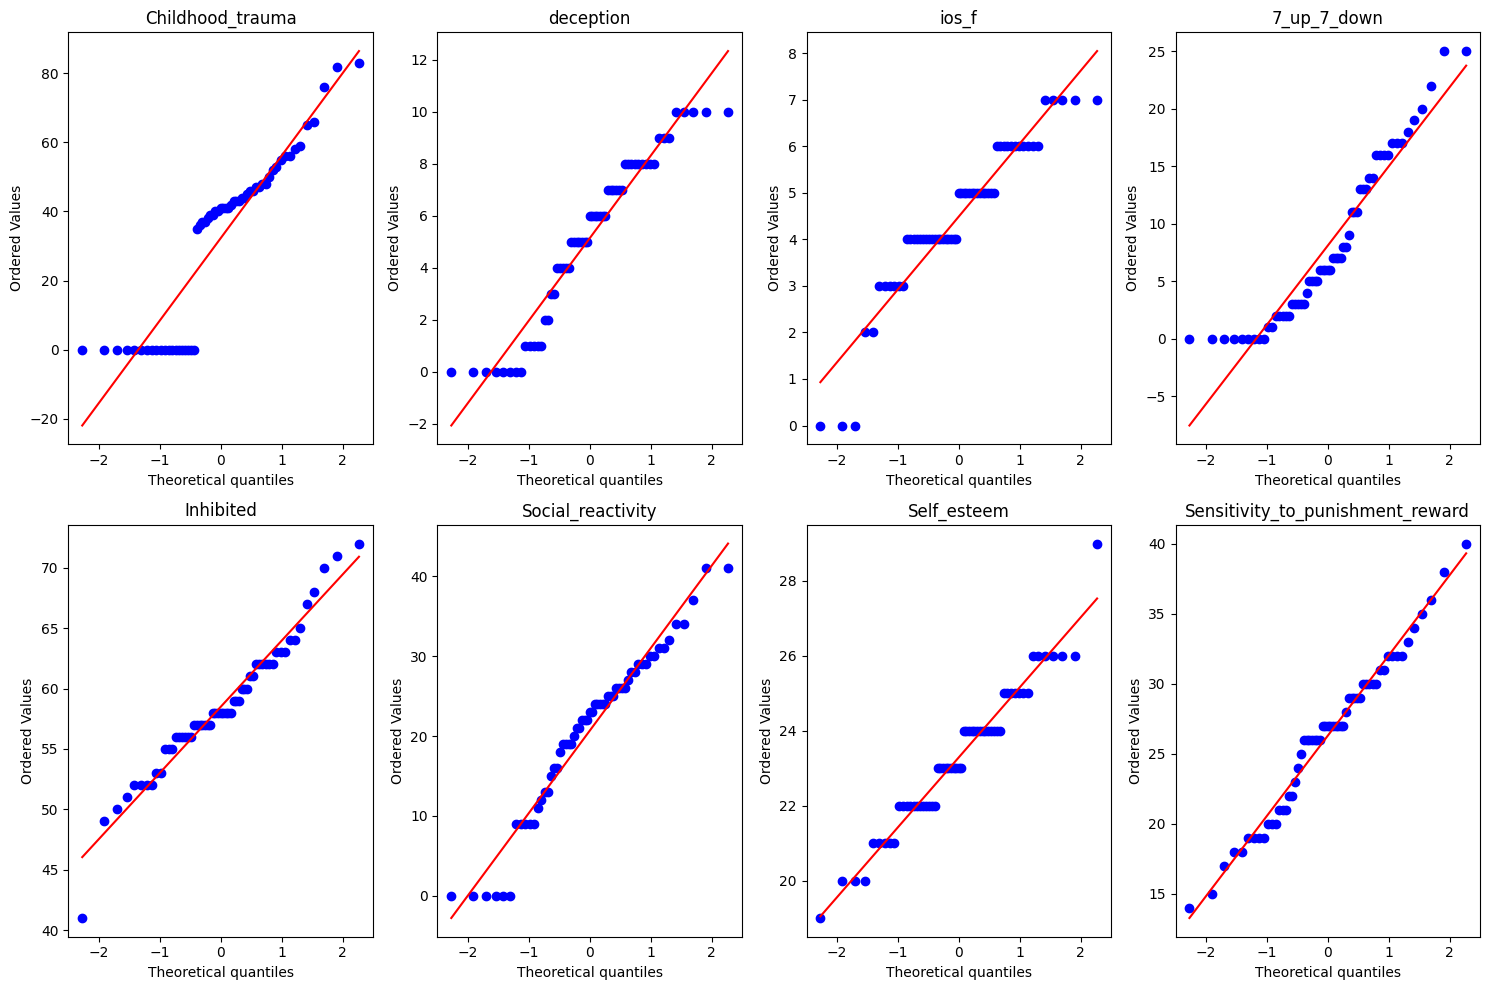

In [96]:
# 'combined_df' is already defined and contains the real data
# Variables to check for Q-Q plot
variables = ["Childhood_trauma", "deception", "ios_f", "7_up_7_down", 
             "Inhibited", "Social_reactivity", "Self_esteem", 
             "Sensitivity_to_punishment_reward"]

# Create Q-Q plots for each variable
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables):
    plt.subplot(2, 4, i+1)
    stats.probplot(combined_df[var].dropna(), dist="norm", plot=plt)
    plt.title(var)

plt.tight_layout()
plt.show()

##### Observations : the four graphs below are considered Gaussian by our previous analysis. We observe a very strong relationship between the line and dots placement. 4 graphs below + the upper-right are all considered suitable, dots follow the trend, so it confirms our previous hypothesis. childhood_trauma, deception, ios_f do not follow evenly the line, and have a lot of dots far away from it. For example, self_esteem and ios_f appear to display similar patterns. However, self_esteem line follows evenly and perfectly dots placement, while ios_f have dots completely out, and even though 2 clusters are distributed evenly, other dots clusters do not follow the line, or are far away from it. A Machine Learning algorithm would train on all dots' clusters, the result would be highly biased by this strong disparity

#### Applying Gaussian distribution normalization

In [97]:
# Box-Cox Transformation that handles zero values
def box_cox_transform_with_zeros(data):
    # Add a small constant to shift all values to be positive
    shifted_data = data + 1
    transformed_data, _ = stats.boxcox(shifted_data)
    return transformed_data

# Apply Box-Cox transformation with zero handling to the specified columns
transformed_columns = ["7_up_7_down", "Inhibited", "Social_reactivity", "Self_esteem", "Sensitivity_to_punishment_reward"]
for col in transformed_columns:
    combined_df[col + '_transformed'] = box_cox_transform_with_zeros(combined_df[col])

# Display the first few rows of the transformed DataFrame
print(combined_df.head())

  participant_id appt1_drugtest  appt1_breathalyzer  deception  \
0       sub-1001       negative                 0.0         10   
1       sub-1002       negative                 0.0          6   
2       sub-1003       negative                 0.0          5   
3       sub-1004       negative                 0.0          3   
4       sub-1006       negative                 0.0          1   

   screen_meds_pastmonth  ios_f  juvenile_drug_alcohol_use  Alcohol_use  \
0                    1.0    5.0                        0.0          6.0   
1                    0.0    5.0                        4.0          0.0   
2                    0.0    4.0                        1.0          5.0   
3                    0.0    3.0                        3.0          4.0   
4                    0.0    4.0                        3.0          1.0   

   Mania_Scale  Autism_Quotient  ...  handedness_Right  screen_race_Asian  \
0          2.0            165.0  ...             False              False  